<a href="https://colab.research.google.com/drive/1COw1BDnON0hUdCuugzbAFwbgEGXHgZ-f?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cache-Augmented Generation (CAG) Explained

This notebook provides an explanation of Cache-Augmented Generation (CAG), its advantages, limitations, and a guide on how to set up and run the provided code for testing CAG.

## What is Cache-Augmented Generation (CAG)?

Retrieval-Augmented Generation (RAG) is a powerful approach that enhances language models by integrating external knowledge. However, RAG faces challenges like retrieval latency, retrieval errors, and system complexity.

**Cache-Augmented Generation (CAG)** is an alternative paradigm designed to bypass real-time retrieval. It leverages the extended context windows of modern Large Language Models (LLMs) by preloading all relevant resources into the model's context and caching its runtime parameters (specifically, the Key-Value (KV) cache). During inference, the preloaded KV-cache allows the model to generate responses directly, eliminating the need for dynamic retrieval.




### Advantages of CAG

- **Reduced Latency**: Eliminates real-time retrieval, leading to faster inference.
- **Improved Reliability**: Minimizes retrieval errors while maintaining context relevance.
- **Simplified Design**: Offers a streamlined, retrieval-free alternative to RAG, capable of achieving comparable or superior results with lower complexity.

### Limitations of CAG

- **Limited Context Size Window of LLM**: CAG requires the entire knowledge source to fit within the context window, making it less suitable for tasks involving extremely large datasets.
- **Context being too large**: The performance of LLMs may degrade with very long contexts.

## **Architectural Overview of CAG and RAG**
<br>

![Difference between RAG and CAG](https://raw.githubusercontent.com/hhhuang/CAG/refs/heads/main/overview.png)

In CAG, the query is appended to the KV Cache and then LLM generates the answer and after that KV Cache is reset to original by truncating query.
So, that the KV Cache size does not keep on increasing, if it would have happened then it would have consumed the whole LLM Context Window.



## Installation

To get started, first ensure you have the necessary dependencies installed. You can do this by running the following command in your terminal:

In [ ]:
!git clone https://github.com/hhhuang/CAG.git
%cd CAG
%pwd

In [ ]:
!pip install -r ./requirements.txt

In [ ]:
!pip uninstall torch torchvision torchaudio --yes
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

## Preparation

Before running the CAG experiments, you need to perform a couple of preparation steps:

### 1. Download Datasets
Download the required `squad` and `hotpotqa` datasets by running the provided curl script:

In [ ]:
!sh ./downloads.sh

Datasets used:
- SQuAD: Dataset which focuses on precise, context-aware answers withing single passages
- HotPotQA: Dataset which focuses on multihop reasoning questions across multiple documents.

### 2. Configure Environment Variables
Insert your `HF_TOKEN` for Hugging Face authentication. If `HF_TOKEN` is not found, the script will raise an error.

To add your HF_TOKEN key to Colab secrets:

1. Click on the "🔑 Secrets" tab in the left sidebar of your Colab notebook.
2. Click the "+" button to add a new secret.
3. In the "Name" field, enter `HF_TOKEN`.
4. In the "Value" field, paste your HF Token.
5. Make sure the "Notebook access" toggle is enabled for this secret.
6. Click "Done".

In [11]:
import os
from google.colab import userdata
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

Create a HF_TOKEN with Write Access, create a new token at https://huggingface.co/settings/tokens


## Setup

Model used here for testing CAG and RAG is **Llama 3.2-1B Model** which has a context size of 128k tokens

In RAG, we comapre the results of CAG with 2 metrics:
  - **BM25 (Sparse Retrieval):**  BM25,a sparse retrieval algorithm, ranks documents based on term frequency inverse document frequency (TF-IDF) and document length normalization
  - **Dense Retrieval System (OpenAI Indexes):**  For a query q, dense retrieval selects the top-k passages p that semantically align with the query,
 offering improved contextual understanding compared to sparse methods.

## Running CAG Experiments with `kvcache.py`

The `kvcache.py` script is designed for running CAG experiments. It preprocesses knowledge into a KV cache and then uses this cache for generating responses to questions, evaluating performance based on semantic similarity and generation time.

### Key Concepts from `kvcache.py`

- **KV Cache (Key-Value Cache)**: In transformer models, the KV cache stores the 'keys' and 'values' from previous token computations. This prevents re-computation for each new token during sequential decoding, significantly speeding up inference.
- **`preprocess_knowledge` function**: This function takes a knowledge prompt, tokenizes it, and runs it through the model to generate the initial KV cache (lines 80-99 in `kvcache.py`). This precomputed cache represents the 'augmented knowledge' in CAG.
- **`write_kv_cache` and `read_kv_cache` functions**: These functions handle saving and loading the precomputed KV cache to/from disk (lines 102-126 in `kvcache.py`). This allows for persistent storage and reuse of the knowledge cache.
- **`generate` function**: This function performs greedy decoding using the pre-existing `past_key_values` (KV cache) to generate new tokens (lines 40-77 in `kvcache.py`). In the CAG context, this `past_key_values` is the knowledge cache.
- **`clean_up` function**: This function truncates the KV cache to its original length, which is important when reusing the same knowledge cache for multiple queries to prevent it from growing indefinitely (lines 114-118 in `kvcache.py`).

### `kvcache.py` Parameters

Here are the important parameters you can use with `kvcache.py`:

- `--kvcache`: Specifies the KV cache method. Use `"file"` to read/write cache from/to a file.
- `--dataset`: The dataset to use for experiments. Options include `"hotpotqa-train"`, `"squad-train"`, `"kis"`, `"kis_sample"`, `"squad-dev"`, `"hotpotqa-dev"`, `"hotpotqa-test"`
- `--similarity`: The similarity metric for evaluation. Currently, `"bertscore"` is supported.
- `--modelname`: The name of the Hugging Face model to use (e.g., `"meta-llama/Llama-3.1-8B-Instruct"`).
- `--maxKnowledge`:  Integer. Selects how many documents from the dataset to use as knowledge.
- `--maxParagraph`:  Integer. Limits the number of paragraphs per knowledge document (default: 100).
- `--maxQuestion`:  Integer. Specifies the maximum number of questions to test.
- `--randomSeed`:  Integer. A random seed number for reproducibility.
- `--output`: String. The filepath to save the results of the experiment.
- `--usePrompt`: (Flag) Add this parameter if you do NOT want to use the CAG knowledge cache acceleration and instead include the knowledge directly in the prompt (disables caching).

### Notes on Parameters

#### `--maxKnowledge` parameter notice:
Approximate Tokens count corresponding to knowledge document size of `"squad-train"` and `"hotpotqa-train"` dataset.

- **`datasets=("squad-train")`**
  - when k = 3, tokens = 21,000
  - when k = 4, tokens = 32,000
  - when k = 7, tokens = 50,000

- **`datasets=("hotpotqa-train")`**
  - all k = 7405 article, tokens = 10,038,084
  - when k = 1, tokens = 1,400
  - when k = 16, tokens = 22,400
  - when k = 24, tokens = 33,667
  - when k = 32, tokens = 44,800
  - when k = 48, tokens = 64,000
  - when k = 64, tokens = 85,000
  - when k = 80, tokens = 106,000

#### `--maxQuestion` parameter notice:
- When using `"squad-train"` dataset, 1 knowledge has an average of 150 questions.
- When using `"hotpotqa-train"` dataset, 1 knowledge has 1 question.

> **TIP:** Since 1 document in `"hotpoqa-train"` dataset has only 1 question, it may not satisfy large-scale evaluation. Multiple evaluations could be a relatively better approach.

### Example Usage - CAG

To run a CAG experiment, you can use a command similar to this:

In [ ]:
!python ./kvcache.py --kvcache file --dataset "squad-train" --similarity bertscore \
    --maxKnowledge 1 --maxParagraph 1 --maxQuestion 1 \
    --modelname "meta-llama/Llama-3.2-8B-Instruct" --randomSeed 0 \
    --output "./result_kvcache.txt"

## Running RAG Experiments with `rag.py`

For comparison purposes, this repository also includes a traditional RAG implementation in `rag.py`. This allows you to benchmark CAG performance against conventional retrieval-augmented generation approaches.

### Key Differences: RAG vs CAG

| Aspect | RAG | CAG |
|--------|-----|-----|
| **Retrieval** | Dynamic, on-demand | Pre-loaded, cached |
| **Latency** | Higher (retrieval overhead) | Lower (no retrieval step) |
| **Knowledge Size** | Can handle large datasets | Limited by context window |
| **Complexity** | Higher system complexity | Simpler, streamlined |
| **Memory Usage** | Lower during inference | Higher (cached knowledge) |
| **Retrieval Errors** | Possible | Eliminated |



### `rag.py` Parameters

Here are the important parameters you can use with `rag.py`:

- `--index`: The indexing method for retrieval. Options: `"openai"` or `"bm25"`
- `--dataset`: The dataset to use for experiments. Options: `"hotpotqa-train"` or `"squad-train"`
- `--similarity`: The similarity metric for evaluation. Currently, `"bertscore"` is supported.
- `--maxKnowledge`: (Optional) Integer. Selects how many documents from the dataset to use as knowledge.
- `--maxParagraph`: (Optional) Integer. Limits the number of paragraphs per knowledge document (default: 100).
- `--maxQuestion`: (Optional) Integer. Specifies the maximum number of questions to test.
- `--topk`: Integer. The number of top similar documents to retrieve for each query.
- `--modelname`: The name of the Hugging Face model to use (e.g., `"meta-llama/Llama-3.1-8B-Instruct"`).
- `--randomSeed`: (Optional) Integer. A random seed number for reproducibility.
- `--output`: String. The filepath to save the results of the experiment.

### Example Usage - RAG

To run a RAG experiment for comparison with CAG, you can use a command similar to this:

In [ ]:
!python ./rag.py --index "bm25" --dataset "hotpotqa-train" --similarity bertscore \
    --maxKnowledge 80 --maxParagraph 100 --maxQuestion 80 --topk 3 \
    --modelname "meta-llama/Llama-3.2-8B-Instruct" --randomSeed 0 \
    --output "./rag_results.txt"

### **NOTE**: You can download the ouptut results from  "Files" tab in the left sidebar of your Colab notebook.

## Mind Map of CAG Process
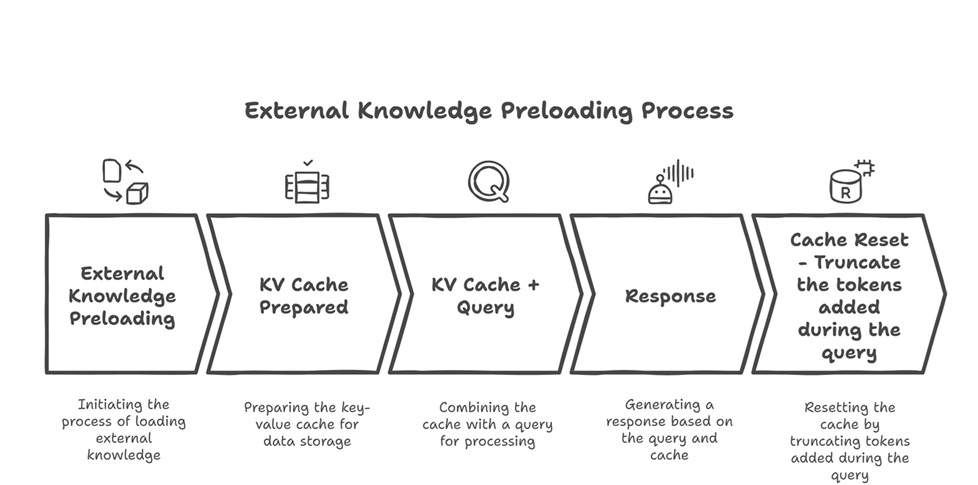